In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

PyTorch version= 1.8.1+cu101
CUDA available= False


In [74]:
# A helper function to display properties of the Python objects
def describe(x):
    print(f"Type= {x.type()}")
    print(f"Shape/size= {x.shape}")
    print(f"Values= {x}")

# Random tensor, has dummy values from the computer memory - not initialized
describe(torch.Tensor(2, 3))

Type= torch.FloatTensor
Shape/size= torch.Size([2, 3])
Values= tensor([[-2.0318e+05,  3.0929e-41,  1.5134e-43],
        [ 1.4714e-43,  1.6115e-43,  1.6255e-43]])


In [75]:
import librosa
import librosa.display

In [76]:
from google.colab import drive
drive.mount("/content/drive")
# 4/1AY0e-g4cDJHhuhb78oBFZAwrylspDu6T3oXYoi-QLTw4Xb6m6Gr8BIac4ZU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. [20 pts] Pre-process a single file using 20 frequency bins (i.e. M), and 2000 sampling frequency (controls the number of data points)

cat_1.wav file (signal) will generate 20 features, and 44 data points. Note that 2000Hz
sampling frequency in fact would ignore frequencies higher than 1000Hz and we assume
cats and dogs sounds are less than that range. Changing that limit to 3k, and 4k are
suggested, but then this will increase the number of data points to be processed.
Display the spectrogram in your notebook

In [77]:
Path_dataset = '/content/drive/MyDrive/JHU/AppliedMachineLearning/audioCatsDog/cats_dogs/'
SAMPLING_FRQ = 2000
M = 20



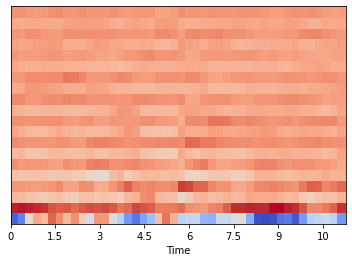

In [78]:
x, fs = librosa.load(Path_dataset+'cat_1.wav', sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

# 2. [20 pts] For each wav file, you will have multiple data points, as generated by the librosa.feature.mfcc. 

Generate the X and y matrices for supervised learning. Apply your
favorite classifier and comment about your results. (Hint: Expect 80-90% 10-fold CV
accuracy, and N, M = 7634, 20)

In [79]:
mfccs.shape

(20, 44)

In [80]:
mfccs[:,0].shape

(20,)

In [81]:
mfccs[0].shape

(44,)

In [82]:
import os

directory = os.path.join(Path_dataset)

Create X,y

In [83]:
%%time
X_list = []
y_list = []
for root,dirs,files in os.walk(directory):
    for file in files:
       if file.endswith(".wav"):
         x, fs = librosa.load(Path_dataset+file, sr=SAMPLING_FRQ)
         mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M)
         for i in range(mfccs.shape[1]):
           X_list.append(mfccs[:,i])
           if file.startswith("cat"):
             y_list.append(0)
           elif file.startswith("dog"):
             y_list.append(1)
    break # avoid recursion

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1884
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1847
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1969
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2032
  n_fft, y.shape[-1]


CPU times: user 42.5 s, sys: 24.5 s, total: 1min 6s
Wall time: 40.1 s


In [84]:
 X = np.asarray(X_list)
 y = np.asarray(y_list)

In [85]:
X.shape

(7634, 20)

In [86]:
y.shape

(7634,)

In [87]:
np.bincount(y)[1]

2396

In [88]:
np.bincount(y)[0]

5238

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [90]:
from sklearn.linear_model import LogisticRegression
pipe_lr = LogisticRegression(random_state=14,
               penalty='l1',
               solver='liblinear',
               max_iter=10000)

In [91]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
     pipe_lr.fit(X[train], y[train])
     score = pipe_lr.score(X[test], y[test])
     scores.append(score)
     print('Fold: %2d, Acc: %.3f' % (k+1, score))
np.mean(scores)

Fold:  1, Acc: 0.792
Fold:  2, Acc: 0.728
Fold:  3, Acc: 0.753
Fold:  4, Acc: 0.826
Fold:  5, Acc: 0.890
Fold:  6, Acc: 0.906
Fold:  7, Acc: 0.934
Fold:  8, Acc: 0.900
Fold:  9, Acc: 0.712
Fold: 10, Acc: 0.710


0.8150592178847619

Comments:

* 10 fold accuracy is about 81.50%
* This is good as there are only 2 labels and random chance would be 50% accuracy


# 3. [50 pts] Train a simple RNN, as given in the module Jupyter notebook, by shuffling the list of the signals (the dataset has 277) and training the network sufficiently (suggested 50 times) and compare its performance to your previous evaluation in step (2.). 

Note that the train method in the module RNN can train a single signal. An epoch can be
the training of all the signals where every signal entails the hidden layer to be initialized and
gradients being reset at the training start

Preprocessing

In [104]:
# %%time
X_list = []
y_list = []
for root,dirs,files in os.walk(directory):
  for file in files:
    if file.endswith(".wav"):
      x, fs = librosa.load(Path_dataset+file, sr=SAMPLING_FRQ)
      mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=M)
      tensor = torch.zeros(mfccs.shape[1], 1, M)
      for i in range(mfccs.shape[1]):
        tensor[i][0] = torch.from_numpy(mfccs[:,i]) # should be of length M
      X_list.append(tensor)
      if file.startswith("cat"):
        y_list.append(torch.tensor([0]))
      elif file.startswith("dog"):
        y_list.append(torch.tensor([1]))
  break # avoid recursion

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1884
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1847
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1969
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2032
  n_fft, y.shape[-1]


Sanity Check

In [105]:
len(X_list)

277

In [106]:
len(y_list)

277

In [107]:
X_list[0].shape

torch.Size([37, 1, 20])

In [134]:
from sklearn.utils import shuffle
X, y = shuffle(X_list, y_list, random_state=42)


In [172]:
import torch.nn as nn
import torch.optim as optim

all_categories = [0,1]

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

class RNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_output, eta=0.0005,epochs=50,minibatch_size=50 ):
        super(RNN, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_features + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_features + n_hidden, n_output)
        self.softmax = nn.LogSoftmax(dim=1)

        self.eta = eta  # learning rate
        
        # loss , since the last layer is nn.LogSoftmax
        self.criterion = nn.NLLLoss()

        self.epochs = epochs  # number of iterations
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work



    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.n_hidden)

    def train_signal(self, sxx, y):
        hidden = self.init_hidden()
        self.zero_grad()

        T = sxx.shape[0]
        for i in range(T):
            output, hidden = self.forward(sxx[i].reshape(1,self.n_features), hidden)
        print('output', output, 'y',y)
        loss = self.criterion(output, y)
        loss.backward()
        
        for p in self.parameters():
            p.data.add_(-self.eta, p.grad.data)

        return output, loss.item()

        
    
    def fit(self, X_train, y_train):
      # Keep track of losses for plotting
      current_loss = 0
      all_losses = []
      print_every = 10
      plot_every = 10
      for i in range(self.epochs):
        for index in range(len(X_train)): # go through all training examples
          output, loss = self.train_signal( X_train[index],y_train[index])
          current_loss += loss

          # Print iter number, loss, name and guess
          if index % print_every == 0:
              guess, guess_i = categoryFromOutput(output)
              correct = '✓' if guess == y_train[index] else '✗ (%s)' % y_train[index]
              print('self.epochs', self.epochs)
              print('%d %d%%  %.4f/ %s %s' % (index, index / self.epochs * 100,  loss, guess, correct))

          # Add current loss avg to list of losses
          if index % plot_every == 0:
              all_losses.append(current_loss / plot_every)
              current_loss = 0
    def predict_signal(self, sxx):
      with torch.no_grad():
        hidden = self.init_hidden()
        T = sxx.shape[0]
        for i in range(T):
          output, hidden = self.forward(sxx[i].reshape(1,self.n_features), hidden)
        guess, guess_i = categoryFromOutput(output)
        return guess
    def predict(self,x_arr):
      y_pred = []
      for sxx in x_arr:
        y_pred.append(self.predict_signal(sxx))
      return y_pred

In [173]:
def kfold_eval_docs(_clf, _Xdocs, _ydocs):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score

    # Need indexable data structure
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_Xdocs, _ydocs):
      X_train = [ _Xdocs[i] for i in train_index]
      y_train = [ _ydocs[i] for i in train_index]
      X_test = [ _Xdocs[i] for i in test_index]
      y_test = [ _ydocs[i] for i in test_index]
      _clf.fit(X_train, y_train)
      y_pred = _clf.predict(X_test)
      print(y_pred)
      acc += [accuracy_score(np.array(y_test), np.array(y_pred))]
    return np.array(acc)

In [174]:
# %%time
clf = RNN(20, 1, 2)

# acc = kfold_eval_docs(clf, torch.tensor(X), torch.tensor(y))
acc = kfold_eval_docs(clf, X, y)


print(f"PyTorch 10-fold CV accuracy= {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}")

Streaming output truncated to the last 5000 lines.
output tensor([[-1.0729e-06, -1.3798e+01]], grad_fn=<LogSoftmaxBackward>) y tensor([0])
output tensor([[-31.8418,   0.0000]], grad_fn=<LogSoftmaxBackward>) y tensor([1])
output tensor([[-0.0150, -4.2049]], grad_fn=<LogSoftmaxBackward>) y tensor([0])
output tensor([[-5.9605e-07, -1.4352e+01]], grad_fn=<LogSoftmaxBackward>) y tensor([0])
output tensor([[-3.0949, -0.0463]], grad_fn=<LogSoftmaxBackward>) y tensor([1])
output tensor([[  0.0000, -21.3199]], grad_fn=<LogSoftmaxBackward>) y tensor([1])
output tensor([[-31.7219,   0.0000]], grad_fn=<LogSoftmaxBackward>) y tensor([1])
self.epochs 50
90 180%  0.0000/ 1 ✓
output tensor([[-0.0062, -5.0884]], grad_fn=<LogSoftmaxBackward>) y tensor([0])
output tensor([[-51.0458,   0.0000]], grad_fn=<LogSoftmaxBackward>) y tensor([1])
output tensor([[-8.0327e-04, -7.1272e+00]], grad_fn=<LogSoftmaxBackward>) y tensor([0])
output tensor([[-29.3448,   0.0000]], grad_fn=<LogSoftmaxBackward>) y tensor([1])

Comments:
* Accuracy was worse than the Logistic Regression Model `71%` vs. `81.50%`.

# 4. [10 pts] Compare and contrast the method applied in this assignment to the image classification

* The image classification assignment was more simple the data preprocessing did not have to account for sequences of variable length.
* The image classificaiton multilayer perceptron however was much more difficult to debug as we had to implement the backpropagation versus the simple `.backward()` function that PyTorch provides. 
* Recurrent neural networks are also very simple to create with layer definition only requiring a simple recursive reference to each layer for feedback. I could not imaging how to code this up from scratch like we did with the MLP in the image classification assignment!